
<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
Digital Image Processing <br>
<font color=2565AE size=5>
Department Of Mathematical Sciences <br>
Spring 2025<br>
<font color=3C99D size=5>
Assignment 2 <br>
</div>


---



### Full Name : Leili Motahari
### Student Number : 
___

In [3]:
# DO NOT MODIFY THIS CELL
import numpy as np
import cv2
from matplotlib import pyplot as plt
import skimage.metrics
from scipy.fftpack import dct, idct

## **Q1: DFT Transformation**

**DFT transform**

In [5]:
def dft(image):
  '''
  function for applying DFT tranform.
  Hint:
    https://numpy.org/doc/stable/reference/generated/numpy.fft.fft2.html

  input(s):
    image (ndarray): input image
  output (s):
    output_image (ndarray): transformed image
  '''
  ###############################################
  ############# YOUR CODE GOES HERE #############

  output_image = np.fft.fft2(image)

  ###############################################
  return output_image

def shift_fft(dft):
  '''
  function for shifting tranformed image.
  Hint:
    https://numpy.org/doc/stable/reference/generated/numpy.fft.fftshift.html

  input(s):
    dft (ndarray): input trandformed image
  output (s):
    output_image (ndarray): shifted transformed image
  '''
  ###############################################
  ############# YOUR CODE GOES HERE #############

  output_image = np.fft.fftshift(dft)

  ###############################################
  return output_image

def inverse_shift(shifted_image):
  '''
  function for inverting shift DFT.
  Hint:
    https://numpy.org/doc/stable/reference/generated/numpy.fft.ifftshift.html

  input(s):
    shifted_image (ndarray): input shifted image
  output (s):
    output_image (ndarray): inverse shifted image
  '''
  ###############################################
  ############# YOUR CODE GOES HERE #############

  output_image = np.fft.ifftshift(shifted_image)

  ###############################################
  return output_image


def idft(image):
  '''
  function for applying IDFT tranform.
  Hint:
    https://numpy.org/doc/stable/reference/generated/numpy.fft.ifft2.html

  input(s):
    image (ndarray): input image
  output (s):
    output_image (ndarray): inverse transformed image
  '''
  ###############################################
  ############# YOUR CODE GOES HERE #############

  output_image = np.fft.ifft2(image)


  ###############################################
  return output_image



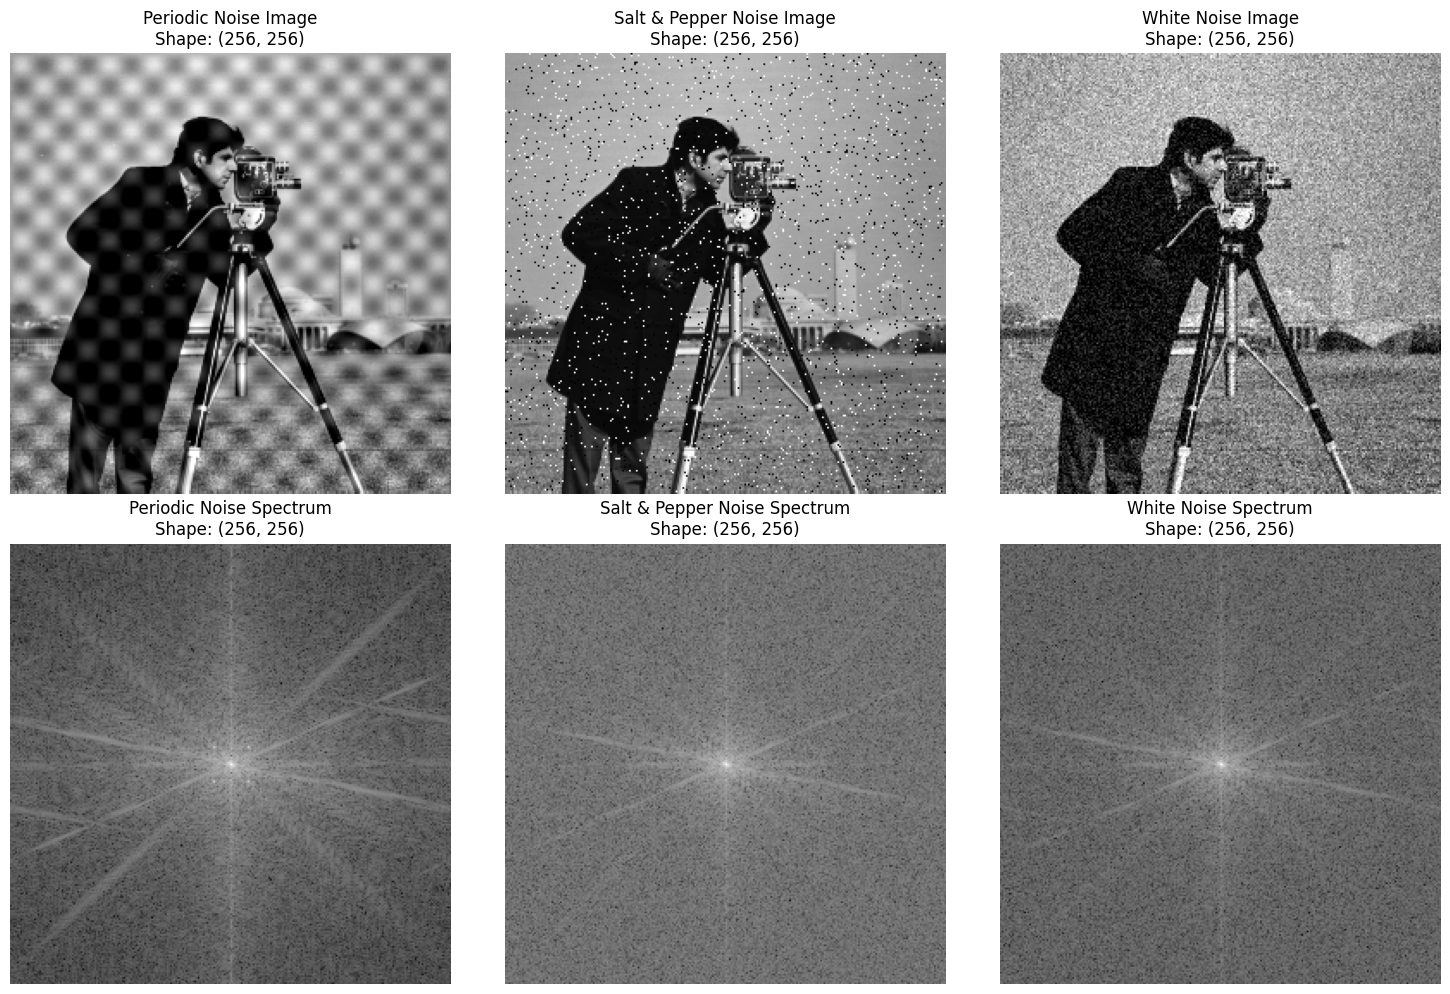

In [ ]:
files = [
    "Images/periodic_noise.png",  
    "Images/salt_and_pepper_noise.png",  
    "Images/white_noise.png"  
]
titles = ["Periodic Noise", "Salt & Pepper Noise", "White Noise"]


fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (fpath, title) in enumerate(zip(files, titles)):
    
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)

    dft_img = dft(img)
    shifted = shift_fft(dft_img)

    magnitude = np.log(1 + np.abs(shifted))

    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f"{title} Image\nShape: {img.shape}")
    axes[0, i].axis('off')

    axes[1, i].imshow(magnitude, cmap='gray')
    axes[1, i].set_title(f"{title} Spectrum\nShape: {magnitude.shape}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


<div style="width: 92%; padding: 2%; font: 20px/28px cursive; border: 10px double yellowgreen; resize: none; overflow: hidden; direction:ltr;"> In the context of noise removal in the frequency domain—especially for **periodic noise**, which appears as distinct points in the frequency spectrum—**shifting the spectrum** is essential. These bright points caused by periodic noise (like those you observed in the previous question) are located at non-standard positions in the unshifted spectrum (for example, at the corners or edges). By shifting the spectrum, these points become clearly visible in **symmetric positions around the center**, making it easier to identify and remove them (by zeroing out or attenuating those specific frequency coefficients). </div>

In [7]:
def ideal_lowpass_filter(shape, cutoff):
    rows, cols = shape
    crow, ccol = rows//2, cols//2
    mask = np.zeros((rows, cols), np.float32)
    y, x = np.ogrid[:rows, :cols]
    mask[np.sqrt((y-crow)**2 + (x-ccol)**2) <= cutoff] = 1
    return mask

def gaussian_lowpass_filter(shape, cutoff):
    rows, cols = shape
    crow, ccol = rows//2, cols//2
    y, x = np.ogrid[:rows, :cols]
    d2 = (y-crow)**2 + (x-ccol)**2
    return np.exp(-d2 / (2 * cutoff**2))

def butterworth_notch_reject(shape, d0, n, centers):
    u, v = np.ogrid[:shape[0], :shape[1]]
    H = np.ones(shape, np.float32)
    for (uk, vk) in centers:
        Dk  = np.sqrt((u-uk)**2 + (v-vk)**2) + 1e-8
        Duk = np.sqrt((u-(shape[0]-uk))**2 + (v-(shape[1]-vk))**2) + 1e-8
        H *= 1 / (1 + (d0/Dk)**(2*n))
        H *= 1 / (1 + (d0/Duk)**(2*n))
    return H

 Periodic Noise 
MSE:  91.6545
PSNR: 28.51 dB
SSIM: 0.9679

 Salt & Pepper Noise 
MSE:  1090.1540
PSNR: 17.76 dB
SSIM: 0.2859

 White Noise 
MSE:  500.1522
PSNR: 21.14 dB
SSIM: 0.5531



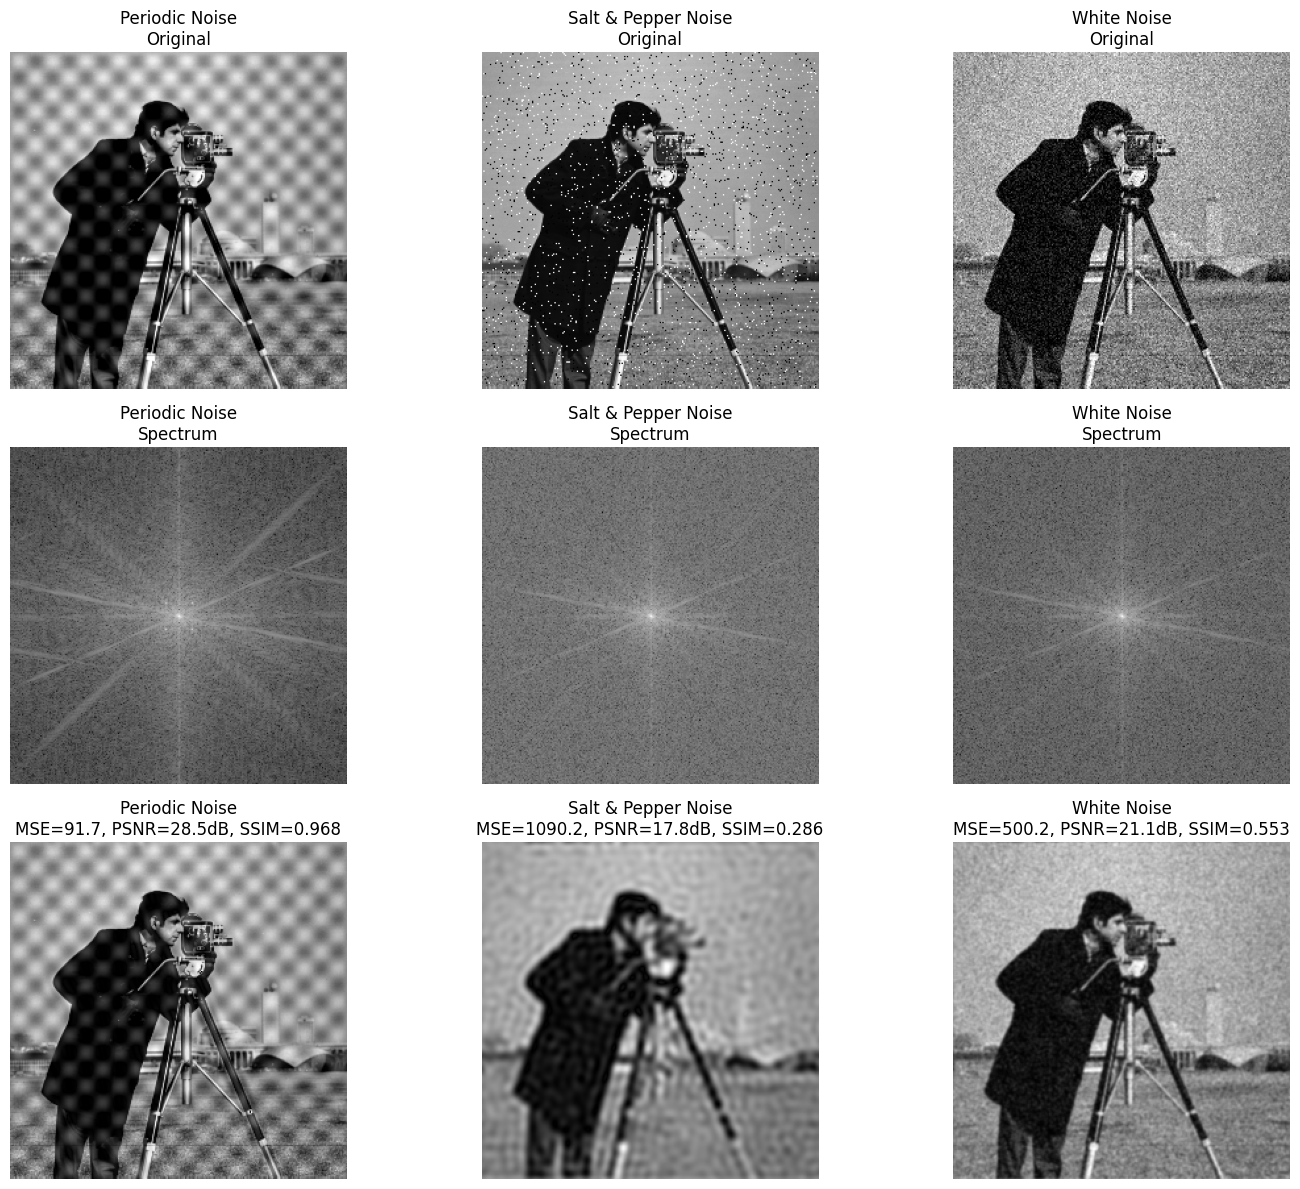

In [8]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

fig, axes = plt.subplots(3, 3, figsize=(15,12))

for i, (path, title) in enumerate(zip(files, titles)):

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    F       = dft(img)
    F_shift = shift_fft(F)
    magnitude = np.log1p(np.abs(F_shift))
    
    if title == "Periodic Noise":
        rows, cols = img.shape
        mag = magnitude.copy()
        R = 20
        mag[rows//2-R:rows//2+R, cols//2-R:cols//2+R] = 0
        flat_idxs = np.argpartition(mag.flatten(), -4)[-4:]
        coords = np.array(np.unravel_index(flat_idxs, mag.shape)).T
        centers = [tuple(c) for c in coords if c[0] < rows//2][:2]
        H = butterworth_notch_reject(img.shape, d0=10, n=2, centers=centers)
    elif title == "Salt & Pepper Noise":
        H = ideal_lowpass_filter(img.shape, cutoff=30)
    else:
        H = gaussian_lowpass_filter(img.shape, cutoff=50)
    
    G_shift      = F_shift * H
    G            = inverse_shift(G_shift)
    img_filtered = np.abs(idft(G)).astype(np.uint8)
    
    mse_val  = mean_squared_error(img, img_filtered)
    psnr_val = peak_signal_noise_ratio(img, img_filtered)
    ssim_val = structural_similarity(img, img_filtered)
    
    axes[0,i].imshow(img, cmap='gray')
    axes[0,i].set_title(f"{title}\nOriginal")
    axes[0,i].axis('off')
    
    axes[1,i].imshow(magnitude, cmap='gray')
    axes[1,i].set_title(f"{title}\nSpectrum")
    axes[1,i].axis('off')
    
    axes[2,i].imshow(img_filtered, cmap='gray')
    axes[2,i].set_title(
        f"{title}\nMSE={mse_val:.1f}, PSNR={psnr_val:.1f}dB, SSIM={ssim_val:.3f}"
    )
    axes[2,i].axis('off')
    
    print(f" {title} ")
    print(f"MSE:  {mse_val:.4f}")
    print(f"PSNR: {psnr_val:.2f} dB")
    print(f"SSIM: {ssim_val:.4f}\n")

plt.tight_layout()
plt.show()


<div style="width: 92%; padding: 2%; font: 20px/28px cursive; border: 10px double yellowgreen; resize: none; overflow: hidden; direction:ltr;"> The **MSE (Mean Squared Error)** is a simple metric that calculates the average of the squared differences in pixel intensities between the original and reconstructed images. A lower MSE value indicates that the overall reconstruction error is smaller, meaning the image is closer to the reference. However, since MSE only measures numeric differences, it ignores the **structural or textural** aspects of an image. Therefore, an image might look blurry or visually degraded while still reporting a low MSE value. <br><br> The **PSNR (Peak Signal-to-Noise Ratio)** is the logarithmic version of MSE, representing the ratio between the maximum possible pixel value and the reconstruction error. PSNR is widely used in signal and image engineering as a quality indicator — higher PSNR values generally mean better reconstruction quality and less noise. Yet, because PSNR is directly derived from MSE, it inherits MSE’s main limitation: **the lack of consideration for visual structure**. <br><br> The **SSIM (Structural Similarity Index)** evaluates image quality based on **structural similarity** between the reference and reconstructed images. Unlike MSE and PSNR, SSIM considers **luminance, contrast, and texture**, focusing on how similar the visual structures and local patterns are. When SSIM approaches 1, it means the reconstructed image is nearly identical to the original in both structure and detail. SSIM is less sensitive to minor brightness or contrast changes and aligns better with **human visual perception** of image quality. </div>

<div style="width: 92%; padding: 2%; font: 20px/28px cursive; border: 10px double yellowgreen; resize: none; overflow: hidden; direction:ltr;"> For **periodic noise**, the **Butterworth Notch Filter** effectively removed the distinct peaks in the spectrum. The low MSE and high PSNR and SSIM (≈0.97) values indicate that most image details were preserved while only the noise frequencies were suppressed. <br><br> In the case of **Salt-and-Pepper noise**, the **Ideal Low-Pass Filter** blurred the noise but did not fully remove it — and also degraded edge details. As a result, the MSE remained very high and the SSIM extremely low. <br><br> For **white noise**, the **Gaussian Filter** moderately reduced the noise; however, since this type of noise is distributed across all frequencies, the PSNR and SSIM values stayed in a medium range. </div>

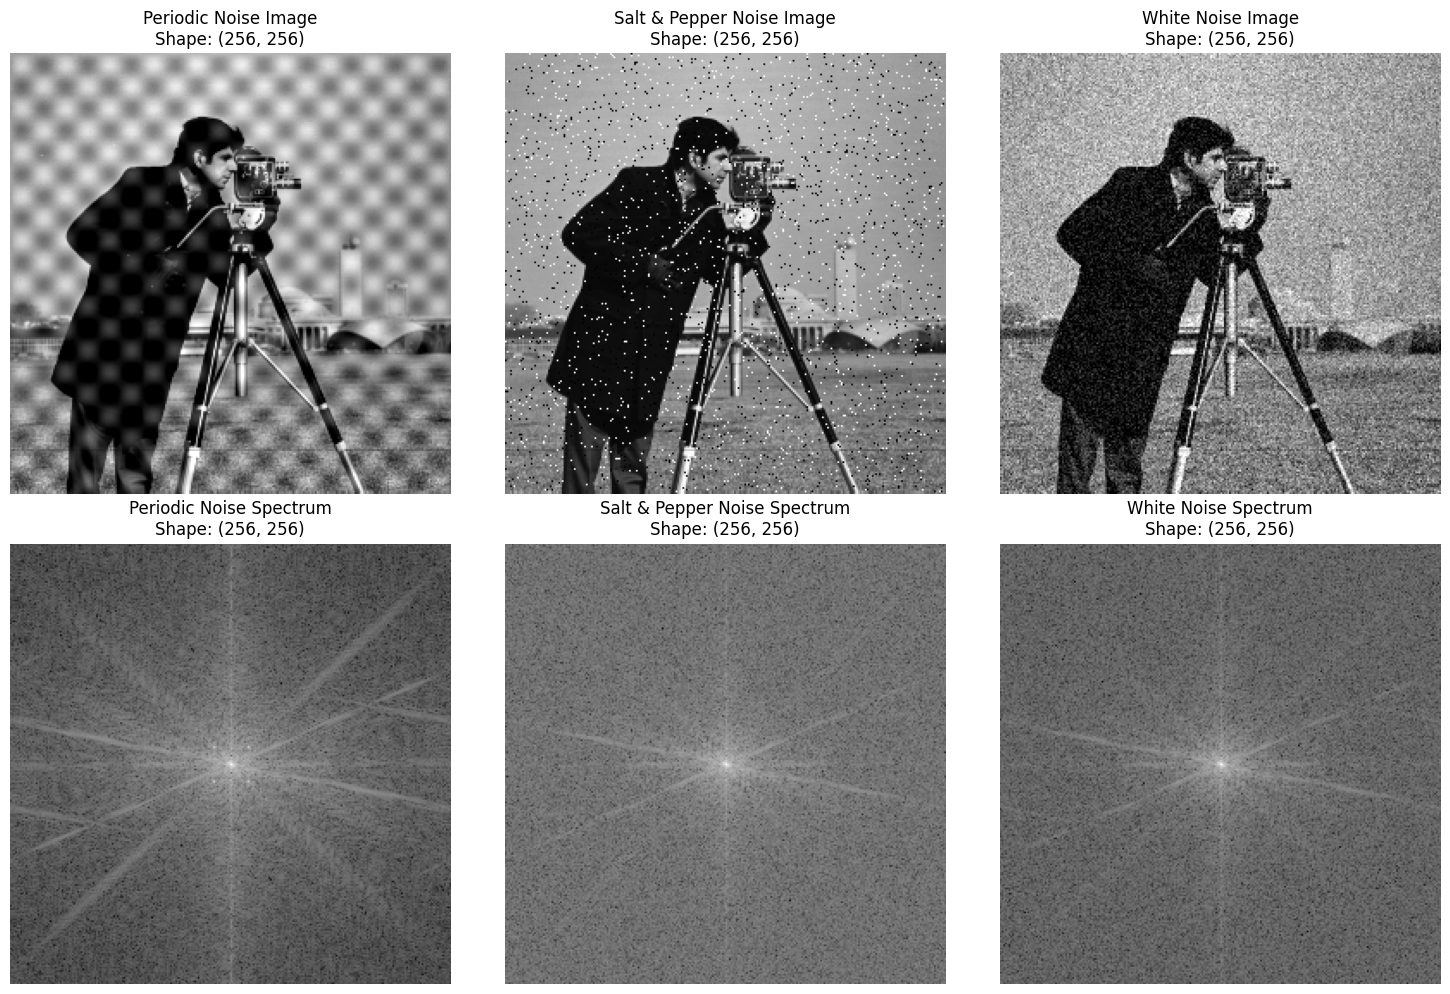

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (fpath, title) in enumerate(zip(files, titles)):
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)

    dft_img = dft(img)
    shifted = shift_fft(dft_img)  

    magnitude = np.log(1 + np.abs(shifted))

    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f"{title} Image\nShape: {img.shape}")
    axes[0, i].axis('off')

    axes[1, i].imshow(magnitude, cmap='gray')
    axes[1, i].set_title(f"{title} Spectrum\nShape: {magnitude.shape}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

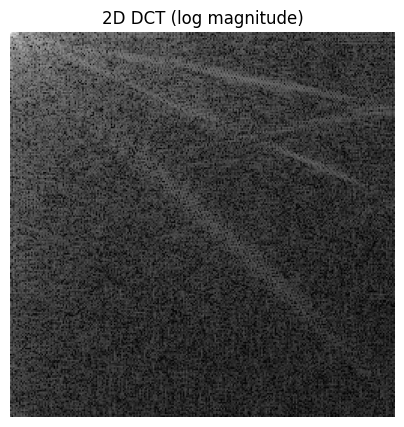

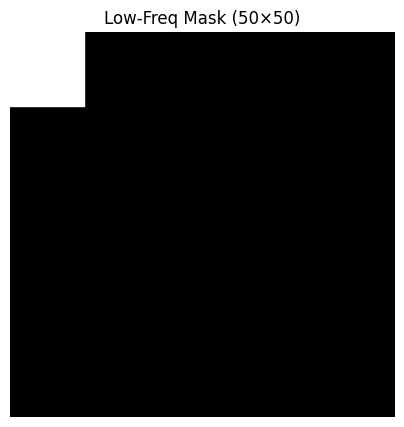

=== Quality Metrics After DCT Compression ===
MSE:  393.6
PSNR: 22.2 dB
SSIM: 0.646


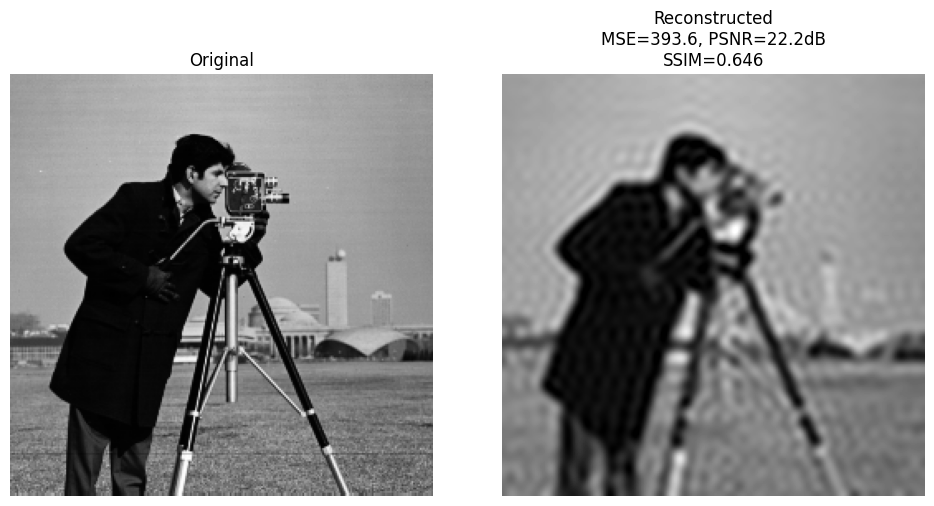

In [ ]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

img = cv2.imread('Images/original_image.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)

dct2 = cv2.dct(img)

plt.figure(figsize=(5,5))
plt.imshow(np.log1p(np.abs(dct2)), cmap='gray')
plt.title('2D DCT (log magnitude)')
plt.axis('off')
plt.show()

N = 50
mask = np.zeros_like(dct2)
mask[:N, :N] = 1

plt.figure(figsize=(5,5))
plt.imshow(mask, cmap='gray')
plt.title(f'Low-Freq Mask ({N}×{N})')
plt.axis('off')
plt.show()

dct2_masked = dct2 * mask
recon = cv2.idct(dct2_masked)
recon_uint8 = np.clip(recon, 0, 255).astype(np.uint8)

mse_val  = mean_squared_error(img, recon)
psnr_val = peak_signal_noise_ratio(img, recon, data_range=255)
ssim_val = structural_similarity(img, recon, data_range=255)

print("=== Quality Metrics After DCT Compression ===")
print(f"MSE:  {mse_val:.1f}")
print(f"PSNR: {psnr_val:.1f} dB")
print(f"SSIM: {ssim_val:.3f}")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img.astype(np.uint8), cmap='gray')
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(recon_uint8, cmap='gray')
plt.title(f'Reconstructed\nMSE={mse_val:.1f}, PSNR={psnr_val:.1f}dB\nSSIM={ssim_val:.3f}')
plt.axis('off')
plt.tight_layout()
plt.show()


<div style="width: 92%; padding: 2%; font: 20px/28px cursive; border: 10px double yellowgreen; resize: none; overflow: hidden; direction:ltr;"> Quantitatively, reconstructing the image while keeping only the **50×50 low-frequency DCT coefficients** resulted in an **MSE ≈ 393**, corresponding to a **PSNR ≈ 22.2 dB** and an **SSIM ≈ 0.65**. These numbers indicate that: <br><br> – The reconstruction error relative to the original image is noticeable (**MSE ≈ 393**). <br><br> – The signal-to-noise ratio (**PSNR ≈ 22 dB**) is moderate for such a strong compression (usually, PSNR above 30 dB is considered visually lossless). <br><br> – The overall structural preservation (**SSIM ≈ 0.65**) shows that roughly two-thirds of the important textures and local details were retained in the reconstruction. <br><br> Qualitatively, the reconstructed image still preserves the **main subject (the photographer and tripod)**, the overall background layout, and the global illumination. However, fine details such as fabric texture, camera outlines, and background grain appear **blurred**, and slight **“ripple-like” artifacts** are visible along edges. This blurring and loss of detail occur because the **high-frequency DCT coefficients** were set to zero. <br><br> In summary, the **DCT** efficiently concentrates most of an image’s energy into low-frequency coefficients, allowing controlled removal of less important high-frequency details. The result is significant data compression while maintaining acceptable perceptual quality in structure and brightness. </div>

## **Q2: Image Cartoonization**

One of the applications of bilateral filters is for adding cartoon effects to color images. In this question we are going to implement the code to cartoonize a given image.

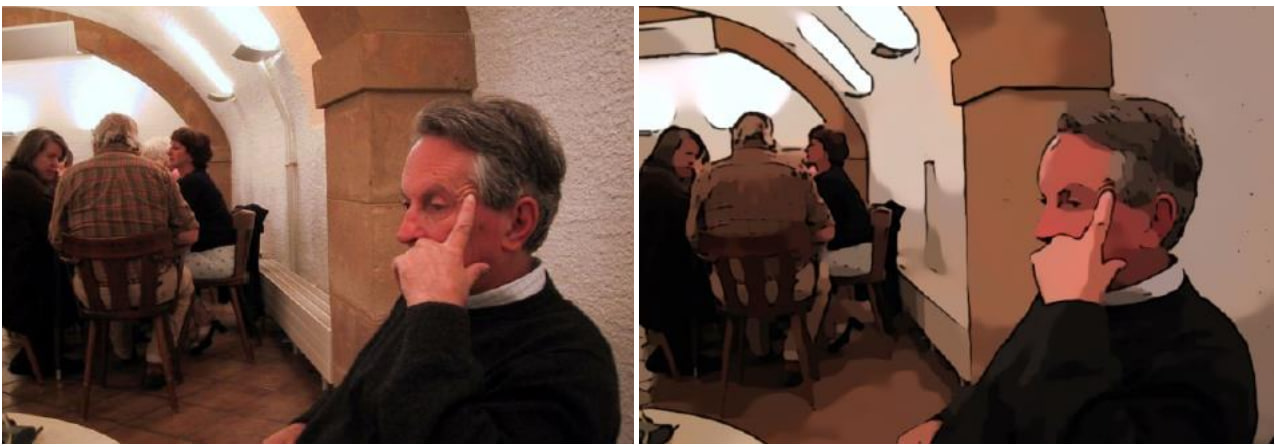

Steps for adding Cartoon effect to the given color image `img`:


1.   Blur `img` using any method you prefer to get `img_blur`.
2.   Use any edge detection method on `img_blur` to get a single channel image `img_edge`, containing the edges.
3.   Apply bilateral filter on the original image `img` to get `img_bf`.
4.   Mix `img_bf` and `img_edges` to get the desired cartoonized image.



In [19]:
def load_q2_image(filename="Q2-input.jpg"):
    return cv2.imread(filename)

In [20]:
input_image_filename = "Images/Q2-input.jpg"
img_original = load_q2_image(input_image_filename)

### Step 1: Edge Detection

Implement `edge_detection` function to get a colored image as input and output a gray image indicating the edges. You are free to use any method you want or use existing functions from `opencv`.

In [22]:
def edge_detection(img : np.ndarray) -> np.ndarray:
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_blur = cv2.GaussianBlur(gray_img, (5, 5), sigmaX=1.5, sigmaY=1.5)

  med_val = np.median(img_blur)
  lower_thresh = int(max(0, 0.67 * med_val)) 
  upper_thresh = int(min(255, 1.33 * med_val))

  edges = cv2.Canny(img_blur, lower_thresh, upper_thresh)

  return edges

Now, Apply the method on `Q2-input.jpg` and save the result as `Q2-output-edges.jpg`. Your score on this part depends on the quality of the result.

In [21]:
output_edges_img = edge_detection(img_original.copy())
cv2.imwrite("Q2-output-edges.jpg", output_edges_img)
print("Saved Q2-output-edges.jpg")

Saved Q2-output-edges.jpg


### Step 2: Bilateral Filter

Implement Bilateral filter. This function should be implemented from scratch and you are not allowed to use any existing function or library other than `numpy`.

In [24]:
def bilateral_filter(img: np.ndarray, d: int, sigma_space: float, sigma_color: float) -> np.ndarray:
    
    if d % 2 == 0:
        raise ValueError("Diameter 'd' must be odd.")
    print(f"bilateral_filter: d={d}, sigma_space={sigma_space}, sigma_color={sigma_color}.")

    img_input_float = img.astype(np.float32)
    original_shape_len = len(img.shape)

    if original_shape_len == 2:  
        img_input_float = np.expand_dims(img_input_float, axis=-1)

    num_channels = img_input_float.shape[2]
    height, width = img_input_float.shape[:2]
    pad_width = d // 2

    x_kernel_offsets, y_kernel_offsets = np.meshgrid(range(-pad_width, pad_width + 1), range(-pad_width, pad_width + 1))
    spatial_dist_sq = (x_kernel_offsets**2 + y_kernel_offsets**2).astype(np.float64)
    spatial_gaussian_kernel = np.exp(-spatial_dist_sq / (2 * sigma_space**2)) 

    padded_img = cv2.copyMakeBorder(img_input_float, pad_width, pad_width, pad_width, pad_width, cv2.BORDER_REFLECT_101)

    from numpy.lib import stride_tricks
    shape = (height, width, d, d, num_channels)
    strides = (padded_img.strides[0], padded_img.strides[1], padded_img.strides[0], padded_img.strides[1], padded_img.strides[2])
    neighborhoods = stride_tricks.as_strided(padded_img, shape=shape, strides=strides)

    filtered_image_accumulator = np.zeros_like(img_input_float, dtype=np.float64)

    for r_orig in range(height):
        for c_orig in range(width):
            neighborhood = neighborhoods[r_orig, c_orig]  
            center_pixel_color_vector = padded_img[r_orig + pad_width, c_orig + pad_width, :]  

            color_diff_sq = np.sum((neighborhood - center_pixel_color_vector) ** 2, axis=2)
            color_gaussian_kernel = np.exp(-color_diff_sq / (2 * sigma_color**2)) 

            
            combined_weights = spatial_gaussian_kernel * color_gaussian_kernel 

            total_weight = np.sum(combined_weights)

            if total_weight == 0:  
                filtered_value = center_pixel_color_vector  
            else:
                weighted_neighborhood_colors = neighborhood * np.expand_dims(combined_weights, axis=-1)
                filtered_value = np.sum(weighted_neighborhood_colors, axis=(0, 1)) / total_weight  

            filtered_image_accumulator[r_orig, c_orig, :] = filtered_value

    final_output_uint8 = np.clip(filtered_image_accumulator, 0, 255).astype(np.uint8)

    if original_shape_len == 2: 
        return final_output_uint8.squeeze(axis=-1)
    else:
        return final_output_uint8


Apply this function on `Q2-input.jpg` and save the result as `Q2-output-bf.jpg`. Use parameters by your choice to get a proper result (blurring should be noticable, but not too much) Your score on this part depends on the quality of the result.

In [ ]:
d_standalone = 11
sigma_space_standalone = 50.0
sigma_color_standalone = 50.0

output_bf_img = bilateral_filter(img_original.copy(), d_standalone, sigma_space_standalone, sigma_color_standalone)
cv2.imwrite("Q2-output-bf.jpg", output_bf_img)
print("Saved Q2-output-bf.jpg")

bilateral_filter: d=11, sigma_space=50.0, sigma_color=50.0. This may take some time...
Saved Q2-output-bf.jpg


In [ ]:
d_standalone = 9  
sigma_space_standalone = 50.0
sigma_color_standalone = 50.0

output_bf_img = bilateral_filter(img_original.copy(), d_standalone, sigma_space_standalone, sigma_color_standalone)
cv2.imwrite("Q2-output-bf.jpg", output_bf_img)
print("Saved Q2-output-bf.jpg")

bilateral_filter: d=9, sigma_space=50.0, sigma_color=50.0. This may take some time...
Saved Q2-output-bf.jpg


### Step 3: Image Cartoonization

Use the previous functions to implement `cartoonize` function. This function takes a colored image `img` and a real number $\alpha$ as input. $\alpha$ will be a real number between 0 and 1, indicating the intensity of cartoonization. $\alpha=0$ means minimal cartoonization; output should be the original image (or very close to it) and as $\alpha$ approaches to 1, cartoonization should be more intense. Note that the dimensionality of the result should be the same as the input. Your score on this part depends on the quality of the result.

In [17]:
def cartoonize(img: np.ndarray, alpha: float) -> np.ndarray:
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)

    if alpha == 0:
        print("cartoonize: alpha=0, returning original image.")
        return img.copy()

    
    img_blur_for_edges = cv2.GaussianBlur(img, (5, 5), sigmaX=1.5, sigmaY=1.5)
    img_edge = edge_detection(img_blur_for_edges) 
    kernel_dilate = np.ones((2,2), np.uint8) 
    img_edge = cv2.dilate(img_edge, kernel_dilate, iterations=1)

    d_bf = 11          
                       
    sigma_space_bf = 100 
    sigma_color_bf = 150 

    print(f"cartoonize: Applying Bilateral Filter (alpha={alpha}, d={d_bf}, ss={sigma_space_bf}, sc={sigma_color_bf})...")
    img_bf = bilateral_filter(img, d_bf, sigma_space_bf, sigma_color_bf)
    print("cartoonize: Bilateral Filter done.")

    cartoon_base = img_bf.copy()
    cartoon_base[img_edge == 255] = [0, 0, 0]

    img_float = img.astype(np.float32)
    cartoon_base_float = cartoon_base.astype(np.float32)

    output_float = (1.0 - alpha) * img_float + alpha * cartoon_base_float
    output_final = np.clip(output_float, 0, 255).astype(np.uint8)

    return output_final

Apply the method on `Q2-input.jpg` for $\alpha=0, 0.25, 0.5, 1$ and save the results as `Q2-output-0.jpg`, `Q2-output-1.jpg`,`Q2-output-2.jpg` and `Q2-output-3.jpg`, respectively.

In [ ]:
alphas_to_test = [0.0, 0.25, 0.5, 1.0]
output_filenames_cartoon = ["Q2-output-0.jpg", "Q2-output-1.jpg", "Q2-output-2.jpg", "Q2-output-3.jpg"]

for i, current_alpha in enumerate(alphas_to_test):
    print(f"\nProcessing cartoonization for alpha = {current_alpha}...")
    cartoon_img_result = cartoonize(img_original.copy(), current_alpha)
    cv2.imwrite(output_filenames_cartoon[i], cartoon_img_result)
    print(f"Saved {output_filenames_cartoon[i]}")

print("\nAll processing complete.")


Executing Step 3: Image Cartoonization...

Processing cartoonization for alpha = 0.0...
cartoonize: alpha=0, returning original image.
Saved Q2-output-0.jpg

Processing cartoonization for alpha = 0.25...
cartoonize: Applying Bilateral Filter (alpha=0.25, d=9, ss=100, sc=150)...
 bilateral_filter: d=9, sigma_space=100, sigma_color=150. This may take some time...
cartoonize: Bilateral Filter done.
Saved Q2-output-1.jpg

Processing cartoonization for alpha = 0.5...
cartoonize: Applying Bilateral Filter (alpha=0.5, d=9, ss=100, sc=150)...
 bilateral_filter: d=9, sigma_space=100, sigma_color=150. This may take some time...
cartoonize: Bilateral Filter done.
Saved Q2-output-2.jpg

Processing cartoonization for alpha = 1.0...
cartoonize: Applying Bilateral Filter (alpha=1.0, d=9, ss=100, sc=150)...
 bilateral_filter: d=9, sigma_space=100, sigma_color=150. This may take some time...
cartoonize: Bilateral Filter done.
Saved Q2-output-3.jpg

All processing complete.
